In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

#    Часть № 1
## Загрузка и преобразование данных

### Загрузка данных


In [2]:
temperature = pd.read_csv('DailyDelhiClimateTrain.csv', index_col = 'date', parse_dates = True)
temperature_test = pd.read_csv('DailyDelhiClimateTest.csv', index_col = 'date', parse_dates = True)
temperature_test = temperature_test['2017-01-01' : '2017-01-07']
display(temperature.head(3))
display(temperature.info())

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.5,0.000000,1015.666667
2013-01-02,7.400000,92.0,2.980000,1017.800000
2013-01-03,7.166667,87.0,4.633333,1018.666667


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


None

### Чекним, есть ли битые данные и если есть, то дропним их

In [3]:
df = temperature.copy()
df_t = temperature_test.copy()
print('Есть ли битые данные:', df.isnull().values.any())
print('Есть ли битые данные:', df_t.isnull().values.any())

Есть ли битые данные: False
Есть ли битые данные: False


### Увеличиваем панель с данными
Добавляем данные о годе, месяце, дне месяца

In [4]:
# Год
df['year'] = df.index.year
# Месяц
df['month'] = df.index.month
# День месяца
df['day'] = df.index.day

# Год
df_t['year'] = df_t.index.year
# Месяц
df_t['month'] = df_t.index.month
# День месяца
df_t['day'] = df_t.index.day

df.tail(5)

,meantemp,humidity,wind_speed,meanpressure,year,month,day
date,,,,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217,2016,12,28
2016-12-29,15.238095,87.857143,6.000000,1016.904762,2016,12,29
2016-12-30,14.095238,89.666667,6.266667,1017.904762,2016,12,30
2016-12-31,15.052632,87.000000,7.325000,1016.100000,2016,12,31
2017-01-01,10.000000,100.000000,0.000000,1016.000000,2017,1,1


In [5]:
#датасет для обучения
df_train = df
df_test = df_t

In [6]:
# выделили вектор целевых переменных 
Y = df_train['meantemp']

Y_t = df_test['meantemp']

In [7]:
# выделили панель с данными 
df_X = df_train.drop('meantemp', axis=1).reset_index(drop=True)
df_test_X = df_test.drop('meantemp', axis=1).reset_index(drop=True)
display(df_X)

,humidity,wind_speed,meanpressure,year,month,day
0,84.500000,0.000000,1015.666667,2013,1,1
1,92.000000,2.980000,1017.800000,2013,1,2
2,87.000000,4.633333,1018.666667,2013,1,3
3,71.333333,1.233333,1017.166667,2013,1,4
4,86.833333,3.700000,1016.500000,2013,1,5
...,...,...,...,...,...,...
1457,68.043478,3.547826,1015.565217,2016,12,28
1458,87.857143,6.000000,1016.904762,2016,12,29
1459,89.666667,6.266667,1017.904762,2016,12,30
1460,87.000000,7.325000,1016.100000,2016,12,31


### кодируем данные по влажности, скорости ветра и давлению

In [8]:
# построили дамми на кварталах, месяцах, днях недели, выходных 
df_dammy=pd.concat(
    [
    df_X[['year','month','day']],
    pd.get_dummies(df_X[['humidity', 'wind_speed', 'meanpressure']])
    ],
    axis=1)
df_dammy.head(5)

,year,month,day,humidity,wind_speed,meanpressure
0,2013,1,1,84.500000,0.000000,1015.666667
1,2013,1,2,92.000000,2.980000,1017.800000
2,2013,1,3,87.000000,4.633333,1018.666667
3,2013,1,4,71.333333,1.233333,1017.166667
4,2013,1,5,86.833333,3.700000,1016.500000


In [9]:
# построили дамми на кварталах, месяцах, днях недели, выходных 
df_dammy_test=pd.concat(
    [
    df_test_X[['year','month','day']],
    pd.get_dummies(df_test_X[['humidity', 'wind_speed', 'meanpressure']])
    ],
    axis=1)
df_dammy_test.head(5)

,year,month,day,humidity,wind_speed,meanpressure
0,2017,1,1,85.869565,2.743478,59.000000
1,2017,1,2,77.222222,2.894444,1018.277778
2,2017,1,3,81.888889,4.016667,1018.333333
3,2017,1,4,70.050000,4.545000,1015.700000
4,2017,1,5,74.944444,3.300000,1014.333333


In [10]:
# values for predicting in the final stage
xx = df_dammy_test.values
yy = Y_t.values

### Начнём обучать модели разными способами

In [11]:
X = df_dammy.values
y = Y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

display(X)
display(y)

array([[2.01300000e+03, 1.00000000e+00, 1.00000000e+00, 8.45000000e+01,
        0.00000000e+00, 1.01566667e+03],
       [2.01300000e+03, 1.00000000e+00, 2.00000000e+00, 9.20000000e+01,
        2.98000000e+00, 1.01780000e+03],
       [2.01300000e+03, 1.00000000e+00, 3.00000000e+00, 8.70000000e+01,
        4.63333333e+00, 1.01866667e+03],
       ...,
       [2.01600000e+03, 1.20000000e+01, 3.00000000e+01, 8.96666667e+01,
        6.26666667e+00, 1.01790476e+03],
       [2.01600000e+03, 1.20000000e+01, 3.10000000e+01, 8.70000000e+01,
        7.32500000e+00, 1.01610000e+03],
       [2.01700000e+03, 1.00000000e+00, 1.00000000e+00, 1.00000000e+02,
        0.00000000e+00, 1.01600000e+03]])

array([10.        ,  7.4       ,  7.16666667, ..., 14.0952381 ,
       15.05263158, 10.        ])

In [12]:
# простенькая моделька и на коленке score БЕЗ ВАЛИДАЦИИ TimeSeriesSplit, а она нужна !!!
print("Правильность моделей без валидации:")

model_1 = KNeighborsRegressor()
model_1.fit(X_train,y_train)
print("Правильность train модели: {:.3f} %".format(model_1.score(X_train,y_train) * 100))
print("Правильность KNN модели: {:.3f} %".format(model_1.score(X_test,y_test) * 100))
print()

model_3 = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
model_3.fit(X_train,y_train)
print("Правильность train модели: {:.3f} %".format(model_3.score(X_train,y_train) * 100))
print("Правильность по бустингу: {:.3f} %".format(model_3.score(X_test,y_test) * 100))
print()

model_3 = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
model_3.fit(X_train,y_train)
print("Правильность train модели: {:.3f} %".format(model_3.score(X_train,y_train) * 100))
print("Правильность по деревьям: {:.3f} %".format(model_3.score(X_test,y_test) * 100))

Правильность моделей без валидации:
Правильность train модели: 92.591 %
Правильность KNN модели: 86.534 %

Правильность train модели: 96.823 %
Правильность по бустингу: 94.543 %

Правильность train модели: 99.318 %
Правильность по деревьям: 94.202 %


In [13]:
n_estimators = [100, 200, 300, 400]

for n in n_estimators:
    model = RandomForestRegressor(n_estimators = n, random_state = 42, n_jobs = -1)
    model.fit(X_train,y_train)
    print("Правильность теста по", n, "листам: {:.3f} %".format(model.score(X_test,y_test) * 100))

Правильность теста по 100 листам: 94.202 %
Правильность теста по 200 листам: 94.199 %
Правильность теста по 300 листам: 94.054 %
Правильность теста по 400 листам: 94.128 %


# Часть № 2
## Итоговая модель с валидацией

In [14]:
# модель с валидацией
model = RandomForestRegressor(n_estimators = 200, random_state = 42, n_jobs = -1)

n_splits = 5
splits = TimeSeriesSplit(n_splits = n_splits, max_train_size = 7*365*24)

for train_index, test_index in splits.split(X):
        train = Y[train_index]
        model.fit(X[train_index], Y[train_index])

print("Правильность модели на основе данных с валидацией: {:.3f} %".format(model.score(X_test, y_test) * 100))

Правильность модели на основе данных с валидацией: 97.053 %


#  Часть № 3
## Предсказывания

In [15]:
dataset = df_dammy_test.copy()
y_predict = model.predict(xx)
model.predict(xx)
dataset['old_meantemp'] = yy
dataset['predicted_meantemp'] = y_predict

dataset

,year,month,day,humidity,wind_speed,meanpressure,old_meantemp,predicted_meantemp
0,2017,1,1,85.869565,2.743478,59.000000,15.913043,24.397292
1,2017,1,2,77.222222,2.894444,1018.277778,18.500000,14.420396
2,2017,1,3,81.888889,4.016667,1018.333333,17.111111,13.804241
3,2017,1,4,70.050000,4.545000,1015.700000,18.700000,15.457940
4,2017,1,5,74.944444,3.300000,1014.333333,18.388889,17.841239
5,2017,1,6,79.318182,8.681818,1011.772727,19.318182,14.528548
6,2017,1,7,95.833333,10.041667,1011.375000,14.708333,14.179128


In [16]:
dtt = dataset[['old_meantemp','predicted_meantemp']]
dtt

,old_meantemp,predicted_meantemp
0,15.913043,24.397292
1,18.500000,14.420396
2,17.111111,13.804241
3,18.700000,15.457940
4,18.388889,17.841239
5,19.318182,14.528548
6,14.708333,14.179128


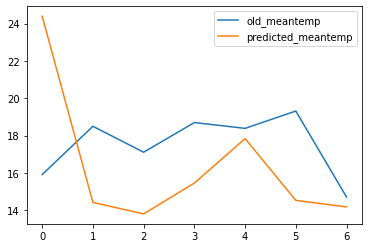

In [17]:
dtt.plot()